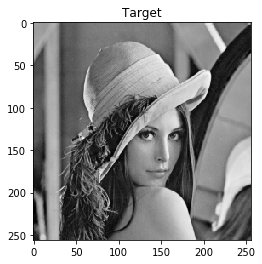

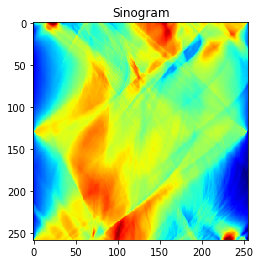

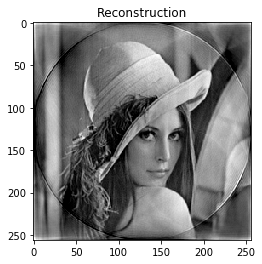

In [9]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import scipy.interpolate
import scipy.fftpack
import scipy.misc
import scipy.ndimage.interpolation
import skimage.transform

lena = plt.imread('lena.png')
S=256 # Size of target, and resolution of Fourier space
N=259 # Number of sinogram exposures (odd number avoids redundant direct opposites)

# Return the angle of the i-th (of 0-to-N-1) sinogram exposure in radians.
def angle(i): 
    radian = (np.pi*i)/N
    degree = np.rad2deg(radian)
    return radian, degree

lena=skimage.transform.resize(lena,(S,S),mode='constant')

plt.figure()
plt.title("Target")
plt.imshow(lena)
plt.gray()

# Calculate radon transform, (we can use Vanya's function instead of this)
sinogram = []
for i in range(N):
    ss = scipy.ndimage.interpolation.rotate(lena,angle(i)[1], order=3, reshape=False, mode='constant', cval=0.0)
    sinogram.append (np.sum(ss, axis=0))  
sinogram = np.array(sinogram)


plt.figure()
plt.title("Sinogram")
plt.imshow(sinogram)
plt.jet()

#Fourier transform the rows of the sinogram shift is needed to make the Fourier series symetric
sinogram_fft_rows=scipy.fftpack.fftshift(scipy.fftpack.fft(scipy.fftpack.ifftshift(sinogram,axes=1)),axes=1)

# Coordinates of sinogram FFT-ed rows' samples in 2D FFT space
a=np.array([angle(i)[0] for i in range(N)])
r=np.arange(S)-S/2
r,a=np.meshgrid(r,a)
r=r.flatten()
a=a.flatten()
srcx=(S/2)+r*np.cos(a)
srcy=(S/2)+r*np.sin(a)

# Coordinates of regular grid in 2D FFT space
dstx,dsty=np.meshgrid(np.arange(S),np.arange(S))
dstx=dstx.flatten()
dsty=dsty.flatten()

# Let the central slice theorem work its magic!
# Interpolate the 2D Fourier space grid from the transformed sinogram rows
fft2=scipy.interpolate.griddata(
    (srcy,srcx),#points
    sinogram_fft_rows.flatten(),#values
    (dsty,dstx),#meshgrid
    method='cubic',
    fill_value=0.0
    ).reshape((S,S))


# Transform from 2D Fourier space back to a reconstruction of the target
recon=np.real(scipy.fftpack.fftshift(scipy.fftpack.ifft2(scipy.fftpack.ifftshift(fft2))))


plt.figure()
plt.title("Reconstruction")
plt.imshow(recon,vmin=0.0,vmax=1.0)
plt.gray()

plt.show()